## Car Price Prediction Machine Learning Project

In this project I will be using a dataset containing different attributes of cars to construct a machine learning model, that can predict the market price of different cars.

In [160]:
#imports
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import seaborn as sns
pd.options.display.max_columns = 99

## Data Cleaning

In [161]:
col_names = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names = col_names)

In [162]:
cars.head(3)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500


The numerical columns are:
* normalized_losses
* num of doors (currently string but should be easy to change to numerical)
* wheel-base
* length
* width
* height
* curb-weight
* cylinders (str type can be changed)
* engine size
* bore
* stroke
* compression-rate
* horsepower
* peak-rpm
* city-mpg
* highway-mpg
* price, but we won't be using this as a feature, since it's our label

In [163]:
cars.replace('?',np.nan, inplace=True)

In [164]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    164 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         203 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 201 non-null object
stroke               201 non-null object
compression-rate     205 non-null float64
horsepower           203 non-nul

In [165]:
column_list = ['normalized-losses','bore','stroke','horsepower','peak-rpm','price']
cars[column_list] = cars[column_list].astype(float)

In [166]:
num_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height',
            'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate',
           'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
print(cars[num_cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
normalized-losses    164 non-null float64
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-size          205 non-null int64
bore                 201 non-null float64
stroke               201 non-null float64
compression-rate     205 non-null float64
horsepower           203 non-null float64
peak-rpm             203 non-null float64
city-mpg             205 non-null int64
highway-mpg          205 non-null int64
price                201 non-null float64
dtypes: float64(11), int64(4)
memory usage: 24.1 KB
None


In [167]:
cars[num_cols].isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

We have a lot of missing values in normalized-losses. Dropping these rows will seriously impact our dataset. For the other columns, I think it would be okay to drop all na rows, since there are so few. price is our tag so we definitly should drop all those rows.
In normalized losses I will replace the values with the mean of the column

In [168]:
cars.loc[cars['normalized-losses'].isnull(), 'normalized-losses'] = cars['normalized-losses'].mean()

In [169]:
cars['normalized-losses'].isnull().sum()

0

In [170]:
cars = cars.dropna(subset=num_cols)

In [171]:
cars.isnull().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         2
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

now we will normalize the numeric columns to have values between 0 and 1

In [172]:
num_cols.remove('price')

In [173]:
cars[num_cols] = (cars[num_cols] - cars[num_cols].min())/(cars[num_cols].max()
                                                              -cars[num_cols].min())

## Machine learning

Now we will start with a rudimentary machine-learning model. For this reason we will start by making a function that trains and tests a K nearest neighbors model on one column of the dataset. We will increase the complexity from here.

In [183]:

df = cars
col_feat = 'length'
col_targ = 'price'

def knn_train_test(col_feat, col_targ = 'price', df = cars, k = 5):
    np.random.seed(1)
    # allowing for the user to either enter a list or a string
    if type(col_feat) == str:
        col_feat = [col_feat]
    # randomizing the dataset
    r_inds = np.random.permutation(df.index)
    df = df.reindex(r_inds)
    # dividing the dataset into a train_set(75%) and a test_set(25%)
    cut_in = int(df.shape[0]*0.75)
    train_set = df.iloc[:cut_in]
    test_set = df.iloc[cut_in:]
    knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors = k)
    knn.fit(train_set[col_feat], train_set[col_targ])
    predictions = knn.predict(test_set[col_feat])
    rmse = sklearn.metrics.mean_squared_error(test_set[col_targ], predictions)**0.5
    return rmse

In [184]:
for col in num_cols:
    print(col, knn_train_test(col))

normalized-losses 6011.397393387372
wheel-base 3899.7840389185753
length 3626.4605069079776
width 4223.196157279122
height 6281.293613872343
curb-weight 4620.6786811339425
engine-size 3600.106719846748
bore 5517.116729611878
stroke 6430.800062391069
compression-rate 6139.234683274987
horsepower 4418.784715096148
peak-rpm 6864.166167830718
city-mpg 3552.957671735319
highway-mpg 4542.0785980672335


The best performing single column with respect to the root_mean_squared is the column 'curb-weight'. This makes sense, because more expensive cars tend to be more expensive. It still seems pretty unreliable, though. The next best-performing column is highway-mpg. This also makes sense, since smaller, cheaper cars tend to be more economic with their fuel. now we want to see how the results are altered if we change the k-value of the model.

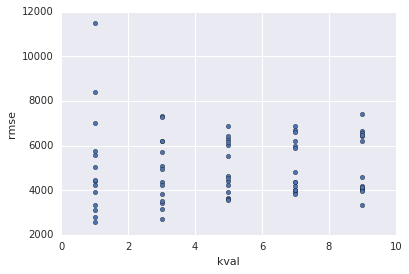

In [185]:
kvaldf = pd.DataFrame()
i = 0
for column in num_cols:
    for k_val in [1,3,5,7,9]:
        kvaldf.loc[i,'column'] = column
        kvaldf.loc[i,'rmse'] = knn_train_test(column, k = k_val)
        kvaldf.loc[i,'kval'] = k_val
        i+=1
kvaldf.plot.scatter(x = 'kval', y = 'rmse')

From this graph we can tell that as we increase our k value, the rmse of the rows that have a high rmse at low k decreases, while the rmse of columns, that start out with a low rmse don't seem to be impacted very much, if at all. This is not surprising, because the rmse of features that don't predict the price very well, will on average get better as they have more neighbors. This is because randomly selecting 5 numbers out of a group and then averaging them and comparing them to the average of the entire population gets better as you approach the entire population. So we might want to think about using the features that have a low rmse (there are two distinct groups) and ignoring those with a high rmse and just using k = 5

In [186]:
def top_rows(n):
    low_re_cols = []
    for column in kvaldf.loc[kvaldf.kval == 5].sort_values('rmse').head(n).column:
        low_re_cols.append(column)
    return low_re_cols

In [187]:
kvaldf.groupby('column').mean().sort_values('rmse')

,rmse,kval
column,,
engine-size,3297.824380,5.0
length,3590.090713,5.0
wheel-base,3754.958064,5.0
city-mpg,3844.973690,5.0
width,3894.302001,5.0
horsepower,4242.336491,5.0
curb-weight,4502.574873,5.0
highway-mpg,4712.440681,5.0
bore,5338.745484,5.0


In [188]:
for i in range(len(num_cols)):
    print(i+1,knn_train_test(top_rows(i+1)))

1 3552.957671735319
2 3502.8709043076224
3 3125.430969270233
4 3301.560096656842
5 2856.670763711649
6 2928.817929974271
7 2935.846197522991
8 2792.3688202978183
9 3256.2279811625785
10 3367.572496257656
11 3748.0602049049103
12 3753.698616086295
13 3429.344126261832
14 3602.891504311049


It seems that at least in respect to rmse values, we are not really improving by adding more, but it should be said, that improving the second one seems to have hurt the most

Now we see what the best k values for the three best models are:

2


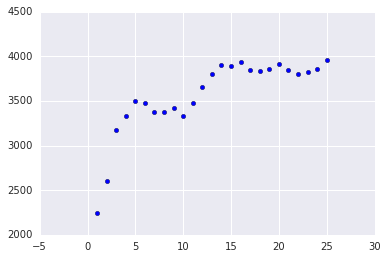

4


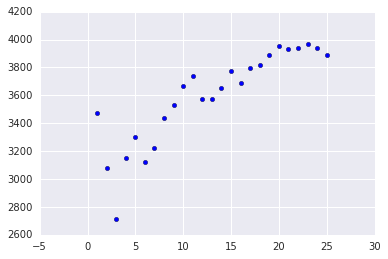

6


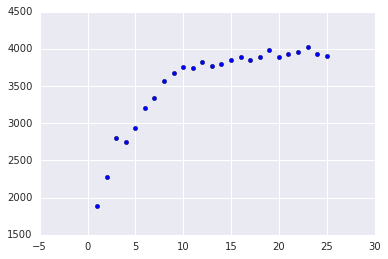

In [189]:

for j in [2,4,6]:
    rmses_k = []
    for i in np.arange(1,26):
        rmses_k.append(knn_train_test(top_rows(j),k = i))
    print(j)
    plt.scatter(x = np.arange(1,26), y = rmses_k)
#     plt.title(title = str(j)+' features used')
    plt.show()

the models have their respective minimum rmses at 1,3,1. This implies, that none of our models are very good.